# Training & Testing Dataset Preparation

### Metadata

In [13]:
import os
import numpy

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
import pandas as pd

# read in train data
TRAINING_DATA_PATH = '../2025_A2/train'
TRAIN_LABEL_PATH = TRAINING_DATA_PATH + '/train_metadata.csv'
IMAGE_DIMENTION = (64, 64)

### Function Definitions



In [16]:
def get_labels(labels_path):
    # load labels as dict 
    labels = {}
    mxm_labels = 0
    with open(labels_path, 'r') as f:
        counter:int = 0
        for line in f:
            # skip the first line
            if counter == 0:
                counter += 1
                continue
            line = line.strip().split(',')
            # line [1] is the image name, line [2] is the label
            labels[line[1]] = int(line[2])
            if int(line[2]) > mxm_labels:
                mxm_labels = int(line[2])
    print(f"Max label: {mxm_labels}")
    return labels

def load_and_preprocess_images(image_folder, labels_dict, target_size=IMAGE_DIMENTION):
    images = []
    labels = []
    
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"): 
            img_path = os.path.join(image_folder, filename)
            
            # Read image with TensorFlow
            img = tf.io.read_file(img_path)  # Read the image file
            img = tf.image.decode_jpeg(img, channels=3)  # Decode the JPEG image (for JPG files)

            # Resize the image to the target size (100x100)
            img_resized = tf.image.resize(img, target_size)
            
            # Normalize image to [0, 1]
            img_normalized = img_resized / 255.0
            images.append(img_normalized)
            
            # Get the label from the dictionary
            label = labels_dict.get(filename)
            labels.append(label)
    
    # Convert lists to numpy arrays
    images = numpy.array(images)
    labels = numpy.array(labels)
    
    return images, labels

# extract the one with highest possibilities
def get_biggest(array_like):
    current_i = 0
    biggest_i = -1
    for i in range(len(array_like)):
        if array_like[i] > biggest_i:
            current_i = i
            biggest_i = array_like[i]
            
    return current_i

### Prepare Data

In [3]:
overall_images, overall_labels = load_and_preprocess_images(TRAINING_DATA_PATH, get_labels(TRAIN_LABEL_PATH))

X_train, X_test, y_train, y_test = train_test_split(overall_images, overall_labels, test_size=0.2, random_state=42)
# train_images, test_images = tf.keras.utils.split_dataset(
#     overall_images, left_size=0.9)

# train_labels, test_labels = tf.keras.utils.split_dataset(
#     overall_labels, left_size=0.9)


Max label: 42


# Model Definition & Model Training

### Definition

In [4]:
def make_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (9, 9), activation='relu', 
                            input_shape=(IMAGE_DIMENTION[0], IMAGE_DIMENTION[1], 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (6, 6), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(43, activation='softmax'))

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
    return model

model = make_cnn_model()
model.summary()

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 56, 56, 32)     │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,923 (730.17 KB)

 Trainable params: 186,923 (730.17 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [12]:
# model.fit(numpy.array(list(train_images)),
#           numpy.array(list(train_labels)),
#           epochs=10, batch_size=64, callbacks=[tb],
#           validation_data=(numpy.array(list(train_images)), numpy.array(list(train_labels))))

model.fit(X_train,
          y_train,
          epochs=10, batch_size=64, 
         )

Epoch 1/10


C:\Users\Administrator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


69/69 [==============================] - 7s 98ms/step - loss: 3.4165 - accuracy: 0.1378
Epoch 2/10
69/69 [==============================] - 7s 97ms/step - loss: 2.3202 - accuracy: 0.3998
Epoch 3/10
69/69 [==============================] - 7s 96ms/step - loss: 1.3349 - accuracy: 0.6330
Epoch 4/10
69/69 [==============================] - 7s 98ms/step - loss: 0.7153 - accuracy: 0.8009
Epoch 5/10
69/69 [==============================] - 7s 97ms/step - loss: 0.4819 - accuracy: 0.8636
Epoch 6/10
69/69 [==============================] - 7s 99ms/step - loss: 0.3025 - accuracy: 0.9153
Epoch 7/10
69/69 [==============================] - 7s 99ms/step - loss: 0.2083 - accuracy: 0.9446
Epoch 8/10
69/69 [==============================] - 7s 98ms/step - loss: 0.1681 - accuracy: 0.9519
Epoch 9/10
69/69 [==============================] - 7s 100ms/step - loss: 0.1204 - accuracy: 0.9677
Epoch 10/10
69/69 [==============================] - 7s 101ms/step - loss: 0.1040 - accuracy: 0.9738


# Save Model

In [15]:
model.save('../models/cnn_model.h5')

# Evaluation

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from scikeras.wrappers import KerasClassifier
import numpy as np
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, balanced_accuracy_score,
                             classification_report, f1_score,
                             roc_auc_score, RocCurveDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

# var adapter
y_pred_raw = model.predict(X_test)
y_pred = []
for predict in y_pred_raw:
    y_pred.append(get_biggest(predict))
y_prob = tf.nn.softmax(y_pred_raw)
X = overall_images
y = overall_labels
# model adapter Keras -> sklearn
clf = KerasClassifier(
        model=make_cnn_model,              # build-function
        epochs=10, batch_size=64,
        verbose=0,                   # silence per-epoch logs
        random_state=42              # for reproducibility
)
    

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Hold-out accuracy : 0.9590163934426229
Balanced accuracy : 0.9369993008768407

Per-class precision / recall / F1

              precision    recall  f1-score   support

           0      0.889     0.889     0.889         9
           1      0.982     0.964     0.973        56
           2      0.925     0.980     0.951        50
           3      1.000     0.905     0.950        42
           4      0.967     0.983     0.975        59
           5      0.912     0.981     0.945        53
           6      1.000     1.000     1.000        14
           7      1.000     0.933     0.966        45
           8      1.000     0.917     0.957        36
           9      0.976     1.000     0.988        41
          10      0.982     1.000     0.991        55
          11      0.952     0.976     0.964        41
          12      1.000     1.000     1.000        65
          13      1.000     0.981     0.991        54
          14      1.000     1.000     1.000        21
          15      0.8

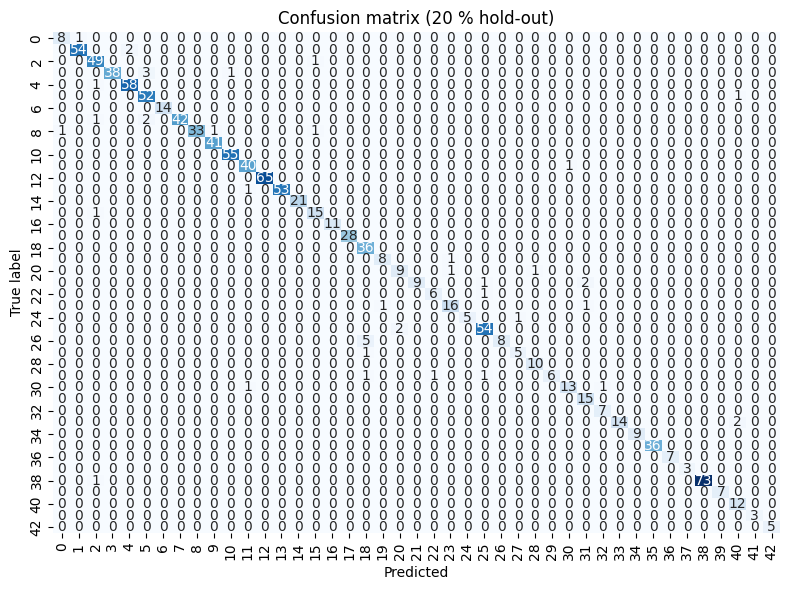

Macro-average ROC-AUC : 0.9969288770414025


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 


5-fold CV accuracy : 0.917 ± 0.011
5-fold CV F1-macro : 0.879 ± 0.012


In [8]:
# -----------------------------------------------------------
# 1.  Basic metrics on the hold-out set
# -----------------------------------------------------------
print("Hold-out accuracy :", accuracy_score(y_test, y_pred))
print("Balanced accuracy :", balanced_accuracy_score(y_test, y_pred))
print("\nPer-class precision / recall / F1\n")
print(classification_report(y_test, y_pred, digits=3))

# -----------------------------------------------------------
# 2.  Confusion-matrix heat-map
# -----------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted"); plt.ylabel("True label")
plt.title("Confusion matrix (20 % hold-out)"); plt.tight_layout(); plt.show()
# -----------------------------------------------------------
# 3.  Macro ROC-AUC (one-vs-rest, micro averaged)
# -----------------------------------------------------------
try:
    roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    print("Macro-average ROC-AUC :", roc_auc)
except Exception as e:
    print("ROC-AUC skipped (classifier lacks predict_proba):", e)

# -----------------------------------------------------------
# 4.  5-fold cross-validation (accuracy & macro-F1)
# -----------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = cross_val_score(clf, X, y,
                             cv=cv, scoring="accuracy", n_jobs=-1)
f1_scores  = cross_val_score(clf, X, y,
                             cv=cv, scoring="f1_macro", n_jobs=-1)

print("\n5-fold CV accuracy : %.3f ± %.3f" % (acc_scores.mean(), acc_scores.std()))
print("5-fold CV F1-macro : %.3f ± %.3f" % (f1_scores.mean(),  f1_scores.std()))

# (Optional) get CV-wide confusion matrix
# y_pred_cv = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
# cm_cv = confusion_matrix(y, y_pred_cv)


# Kaggle

In [5]:
kaggle_model = make_cnn_model()

# train model on all datasets (no test split)
kaggle_model.fit(overall_images,
          overall_labels,
          epochs=12, batch_size=64, 
         )

Epoch 1/12


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.1114 - loss: 3.4974
Epoch 2/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5510 - loss: 1.7393
Epoch 3/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7750 - loss: 0.8431
Epoch 4/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8745 - loss: 0.4730
Epoch 5/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9154 - loss: 0.3071
Epoch 6/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9496 - loss: 0.2012
Epoch 7/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9638 - loss: 0.1465
Epoch 8/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9784 - loss: 0.0855
Epoch 9/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9802 - loss: 0.0759
Epoch 10/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9867 - loss: 0.0532
Epoch 11/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9839 - loss: 0.0544
Epoch 12/12
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9798 - l

In [ ]:
# prepare test data
TEST_DATA_PATH = '../2025_A2/test'

# output dict should follow this structure:
###### {image_dir:predicted_class} #####
output:dict = {}
for filename in os.listdir(TEST_DATA_PATH):
    if filename.endswith(".jpg"): 
        img_path = os.path.join(TEST_DATA_PATH, filename)
        img_name = img_path.split('/')[-1]

        # Read image with TensorFlow
        img = tf.io.read_file(img_path)  # Read the image file
        img = tf.image.decode_jpeg(img, channels=3)  # Decode the JPEG image (for JPG files)

        # Resize the image to the target size (100x100)
        img_resized = tf.image.resize(img, IMAGE_DIMENTION)
        
        # Normalize image to [0, 1] and pridict the label from the model
        label = None
        kaggle_pred_raw = kaggle_model.predict(numpy.expand_dims(img_resized / 255.0, axis=0))
        label = get_biggest(kaggle_pred_raw[0])

        output[img_name] = int(label)
        
print(output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [ ]:
# read test data as pandas
test_df = pd.read_csv(TEST_DATA_PATH + '/test_metadata.csv')

# merge the `output` dict to pandas
test_df['ClassId'] = test_df['ClassId'].fillna(test_df['image_path'].map(output))
test_df['ClassId'] = test_df['ClassId'].astype('Int64') 
test_df = test_df.drop('image_path', axis=1)
# save to new csv
test_df.to_csv("../kaggle_filled.csv", index=False)

In [ ]:
df_original = pd.read_csv(TEST_DATA_PATH + '/test_metadata.csv')
df_verify = pd.read_csv('../cnn_out.csv')

print(df_original.shape)
print(df_verify.shape)

(2353, 3)
(2353, 2)
